# Sources
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/optimize-pytorch-performance-for-speed-and-memory-efficiency-2022-84f453916ea6

Imports

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
import glob
import mimetypes
import itertools
from typing import Iterable,Generator,Sequence,Iterator,List,Set,Dict,Union,Optional,Tuple
import meta_utils
import pandas as pd
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import StratifiedKFold

from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import albumentations as A
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2
import cv2

sns.set()

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
cudnn.benchmark = True

# Config

In [2]:

def fish_name_fn(x): return str(x).split("/")[-2]
def asl_name_fn(x): return str(x).split("/")[-2]

experiment_name = "test_asl_starter"
ds_path = Path("/media/hdd/Datasets/asl/")
ds_name = "asl"
name_fn = asl_name_fn
image_size = 224
batch_size = 128
epoch_steps = [1,2]
enable_proxy_attention = True
change_subset_attention = 0.01
validation_split = 0.3
shuffle_dataset = True
num_gpu = 1
transfer_imagenet = False
subset_images = 5000 # for testing purposes

os.makedirs("runs/", exist_ok=True)
fname_start = f'runs/{ds_name}_{experiment_name}+{datetime.datetime.now().strftime("%d%m%Y_%H:%M:%S")}_subset-{subset_images}'  # unique_name
print(f"[INFO] : File name = {fname_start}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[INFO] : File name = runs/asl_test_asl_starter+04122022_16:07:18_subset-5000


In [3]:
data_transforms = {
    'train':  A.Compose(
        [
            A.RandomResizedCrop(image_size, image_size, p=1.0),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
    ),
    'val': A.Compose([
        A.Resize(image_size, image_size),
        A.CenterCrop(image_size, image_size, p=1.0),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
        ToTensorV2(p=1.0),
    ],
        p=1.0,
    )

}


# Data part

In [148]:
# Get all image files

all_files = meta_utils.get_files(ds_path/"train")
if subset_images !=None:
    all_files = all_files[:subset_images]

# Put them in a data frame for encoding
df = pd.DataFrame.from_dict(
    {x: name_fn(x) for x in all_files}, orient="index"
).reset_index()
df.columns = ["image_id", "label"]

In [5]:
# df["label"].value_counts()

In [149]:
# Convert labels to integers
temp = preprocessing.LabelEncoder()
df["label"] = temp.fit_transform(df.label.values)

# Save label map
label_map = {i: l for i, l in enumerate(temp.classes_)}

# Kfold splits
df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
stratify = StratifiedKFold(n_splits=2)
for i, (t_idx, v_idx) in enumerate(
    stratify.split(X=df.image_id.values, y=df.label.values)
):
    df.loc[v_idx, "kfold"] = i
df.to_csv("train_folds.csv", index=False)

In [7]:
class ImageClassDs(Dataset):
    def __init__(
        self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms=None
    ):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        self.classes = self.df["label"]

    def __getitem__(self, index):
        im_path = self.df.iloc[index]["image_id"]
        x = cv2.imread(str(im_path), cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        if self.transforms:
            x = self.transforms(image=x)["image"]

        y = self.df.iloc[index]["label"]
        return {
            "x": x,
            "y": y,
        }

    def __len__(self):
        return len(self.df)

In [8]:
train = df.loc[df["kfold"] != 1]
val = df.loc[df["kfold"] == 1]
image_datasets = {
    "train": ImageClassDs(train, ds_path, train=True, transforms=data_transforms["train"]),

    "val": ImageClassDs(val, ds_path, train=False, transforms=data_transforms["val"]),
}

dataloaders = {
    "train": torch.utils.data.DataLoader(
        image_datasets["train"],
        batch_size=batch_size,
        shuffle=True, num_workers=4* num_gpu, pin_memory = True),
        
    "val": torch.utils.data.DataLoader(
        image_datasets["val"],
        batch_size=batch_size,
        shuffle=False, num_workers=4*num_gpu, pin_memory = True),
    }


In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Model Defs

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter(log_dir=fname_start, comment = fname_start)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    pbar = tqdm(range(num_epochs), total=num_epochs)
    for epoch in pbar:
        # print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.

            optimizer.zero_grad(set_to_none=True)
            scaler = torch.cuda.amp.GradScaler()
            for inps in tqdm(dataloaders[phase], total=len(dataloaders[phase]), leave = False):
                inputs = inps['x'].to(device, non_blocking=True)
                labels = inps['y'].to(device, non_blocking=True)

                # zero the parameter gradients

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        if phase == 'train':
                            outputs = model(inputs)
                        else:
                            with torch.no_grad():
                                outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        # optimizer.step()

                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad(set_to_none=True)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix({
                    'Phase': "running",
                    'Loss': running_loss/dataset_sizes[phase],
                    # 'Acc' : running_corrects.double() / dataset_sizes[phase],
                })

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            pbar.set_postfix({
                'Phase': phase,
                'Loss': epoch_loss,
                'Acc': epoch_acc
            })
            if phase == 'train':
                writer.add_scalar('Loss/Train', epoch_loss, epoch)
                writer.add_scalar('Acc/Train', epoch_acc, epoch)
            if phase == 'val':
                writer.add_scalar('Loss/Val', epoch_loss, epoch)
                writer.add_scalar('Acc/Val', epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [19]:
num_classes = len(label_map.keys())

In [20]:

if transfer_imagenet == True:
    model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model_ft.parameters():
        param.requires_grad = False
else:
    model_ft = models.resnet18(weights=None)
    for param in model_ft.parameters():
        param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Proxy Attention

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=10)


100%|██████████| 10/10 [00:42<00:00,  4.24s/it, Phase=val, Loss=0.671, Acc=tensor(0.6000, device='cuda:0', dtype=torch.float64)]    

Training complete in 0m 42s
Best val Acc: 0.600400


In [37]:
torch.save(model_ft.state_dict(), Path(fname_start)/"model.pt")

In [38]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [40]:
model_ft.eval();

In [143]:
inps = next(iter(dataloaders['train']))
inputs = inps['x'].to(device, non_blocking=True)
labels = inps['y'].to(device, non_blocking=True)
outputs = model_ft(inputs)
_, predicted = torch.max(outputs, 1)

In [41]:
def attribute_image_features(model, ind, algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [313]:
len(label_map)

2

In [330]:
saliency = Saliency(model_ft)
# ind = 10
# temp_inp, temp_out = torch.Tensor([inputs[ind].unsqueeze(0) for ind in range(len(label_map))]), torch.Tensor([labels[ind].item() for ind in range(len(label_map))])
# temp_inp = [x.requires_grad = True for x in temp_inp]
grads = saliency.attribute(inputs, labels)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (0,2,3,1))


In [331]:
print(grads.shape)

(128, 224, 224, 3)


In [341]:
# _ = viz.visualize_image_attr(grads[10], grads[10], 
#                        title="Original Image", show_colorbar = False)


: 

In [283]:
def normalize_scale(attr: np.ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)

In [284]:
def cumulative_sum_threshold(values: np.ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

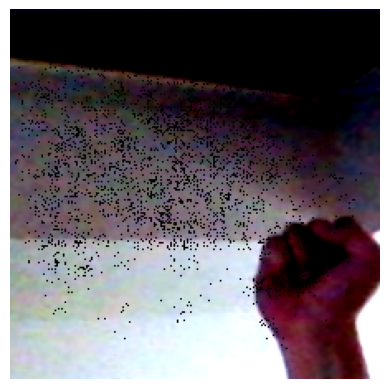

In [308]:
temp_im = normalize_scale(np.abs(grads),cumulative_sum_threshold(np.abs(grads), 100-2))
# plt.imshow(temp_im)

original_image[grads.mean(axis = 2) > 0.008] = 0.0
plt.imshow(original_image)
plt.axis('off')

In [ ]:
norm_attr = _normalize_attr(attr, sign, outlier_perc, reduction_axis=2)

In [199]:
np.min(grads)

5.5009878e-08

In [213]:
temp_out

0

In [238]:
labels[ind]

tensor(0, device='cuda:0')

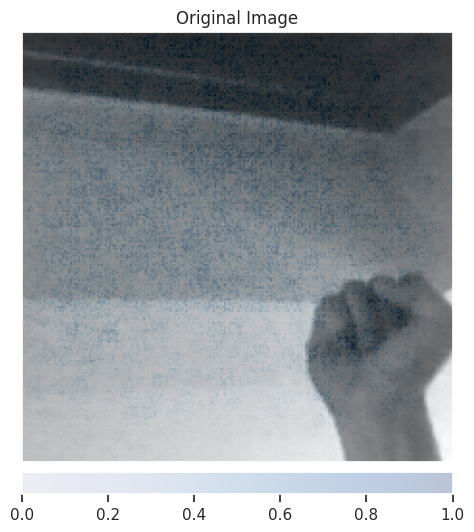

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


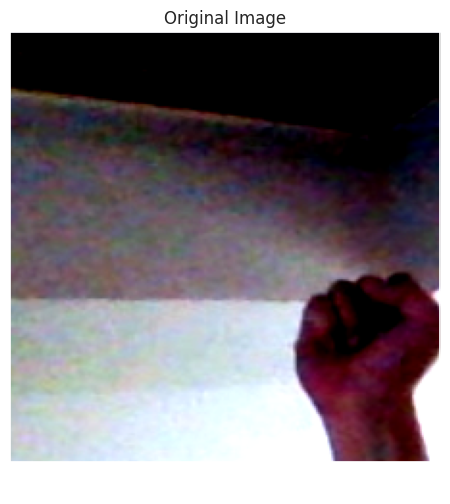

0.009 tensor([1], device='cuda:0')


In [299]:
var = 0.009
original_image = np.transpose((inputs[ind].cpu().detach().numpy() / 2) + 0.5, (1,2,0))
# original_image[grads.mean(axis = 2) > var] = 0.0
# original_image = original_image * grads
_ = viz.visualize_image_attr(grads, original_image, 
                      method="blended_heat_map", title="Original Image",alpha_overlay = 0.2, show_colorbar = True)
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image",alpha_overlay = 0.2, show_colorbar = True)


# plt.imshow(original_image)
# grad_im[0]
# plt.axis('off')
_, predicted = torch.max(model_ft(data_transforms['val'](image = original_image)['image'].unsqueeze(0).to(device)),1)
print(var, predicted)

In [239]:
for var in np.arange(0.0001,0.02, 0.001):
    original_image = np.transpose((inputs[ind].cpu().detach().numpy() / 2) + 0.5, (1,2,0))
    original_image[grads.mean(axis = 2) > var] = 0.0
    # _ = viz.visualize_image_attr(None, original_image, 
                        #   method="original_image", title="Original Image")

    # plt.imshow(original_image)
    # plt.axis('off')
    _, predicted = torch.max(model_ft(data_transforms['val'](image = original_image)['image'].unsqueeze(0).to(device)),1)
    print(var, predicted)

0.0001 tensor([1], device='cuda:0')
0.0011 tensor([1], device='cuda:0')
0.0021 tensor([1], device='cuda:0')
0.0031 tensor([1], device='cuda:0')
0.0041 tensor([1], device='cuda:0')
0.0051 tensor([1], device='cuda:0')
0.0061 tensor([1], device='cuda:0')
0.0071 tensor([1], device='cuda:0')
0.0081 tensor([1], device='cuda:0')
0.0091 tensor([1], device='cuda:0')
0.0101 tensor([1], device='cuda:0')
0.011099999999999999 tensor([1], device='cuda:0')
0.0121 tensor([1], device='cuda:0')
0.0131 tensor([1], device='cuda:0')
0.0141 tensor([1], device='cuda:0')
0.015099999999999999 tensor([1], device='cuda:0')
0.0161 tensor([1], device='cuda:0')
0.0171 tensor([1], device='cuda:0')
0.0181 tensor([1], device='cuda:0')
0.0191 tensor([1], device='cuda:0')
